# 生成数据

In [1]:
import numpy as np 
import pylab as plt

In [80]:
# Define signal
t = np.linspace(0, 1, 100)
s = np.cos(11*2*np.pi*t*t) + 6*t*t 

Text(0.5, 0, 'Time [s]')

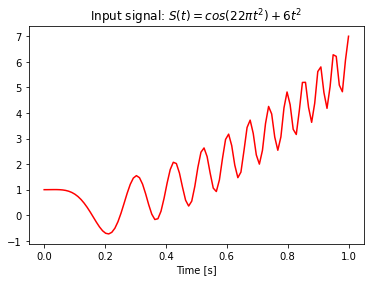

In [81]:
# Plot results
plt.subplot(1, 1, 1)
plt.plot(t, s, 'r')
plt.title("Input signal: $S(t)=cos(22\pi t^2) + 6t^2$")
plt.xlabel("Time [s]")

# 模型算法
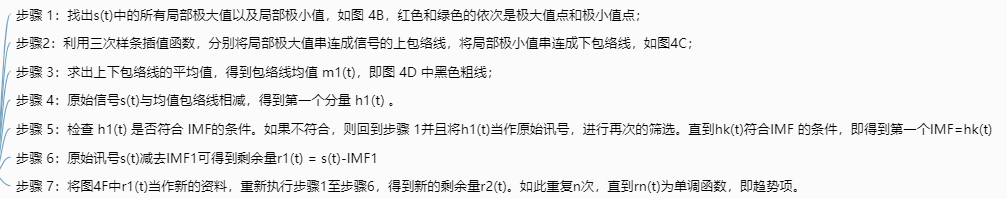

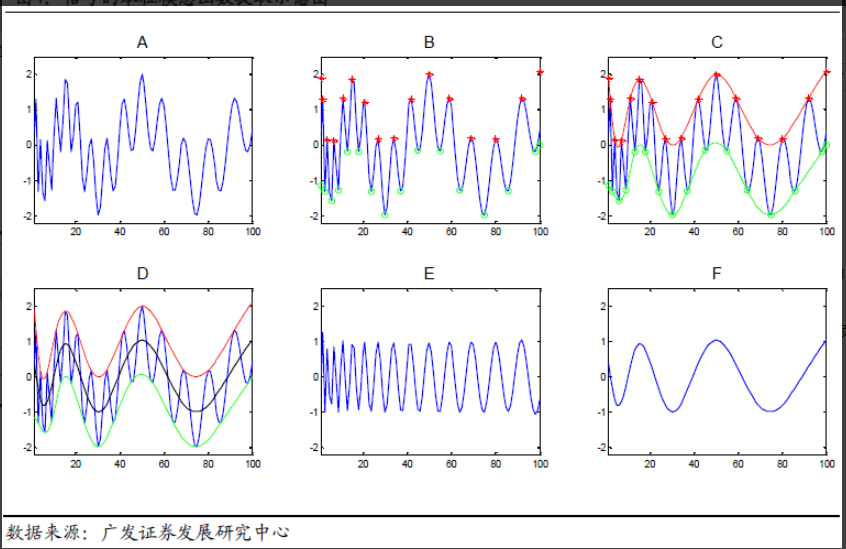

In [74]:
a = np.array([[5,6,7],
              [4,5,6],
              [2,3,4]])



array([[1., 1., 1.],
       [2., 2., 2.],
       [2., 3., 4.]])

In [82]:
from scipy import interpolate
import pandas as pd 
import numpy as np 

class EMD():
    def __init__(self):
        pass
        
    def emd(self, S, T, max_imf=-1, if_check_imf=False):
        """ 经验模式分解函数 

            Parameters
            ----------
            S : numpy array,
                Input signal.
            T : numpy array, (default: None)
                Position or time array. If None is passed, numpy range is created.
            max_imf : int, (default: -1)
                IMF number to which decomposition should be performed.
                Negative value means *all*.
            Returns
            -------
            IMF : numpy array
                Set of IMFs produced from input signal.
        """ 
        n = 1                
        r = np.r_[[S]]
        T = np.array(range(len(T)))
        
        finished = False
        while not finished:
            """ 计算新的rn和h """
            h = r[-1].copy()
            # print(h)
            while True:
                """ 找到h的极值点，0交叉点 """
                max_pos, max_val, min_pos, min_val, ind0 = self.find_extrema(h, T)
                
                """ 检查h是否趋势项 """
                if len(max_pos)+len(min_pos)<2: 
                    finished = True
                    break
                    
                # print(h.shape)
                # print(max_pos)
                # print(min_pos)
                # print(max_val)
                # print(min_val)
                
                """ 对h三次样条求上下包络 """
                max_spline, min_spline = self.extract_max_min_spline(S, T, max_pos, max_val, min_pos, min_val)
                
                """ h减去上下包络线均值 """
                m = (max_spline + min_spline)/2
                h = h - m
                
                if if_check_imf and not self.check_imf(h, max_pos, max_val, min_pos, min_val):
                    """ 检查是否IMF，不满足则继续对h进行上述步骤 """
                    continue
                else:
                    """ 无需检查IMF，或检查后h满足IMF，将r(n-1)-h加至r的最后一行，跳出 """
                    #print(h)
                    r_n = r[-1] - h
                    r = np.r_[ r, [r_n]]
                    break
        IMF = r - np.r_[r[1:], np.zeros(shape=(1, len(T)))]
        return IMF
    
    def find_extrema(self, S: np.ndarray, T: np.ndarray):
        """  找到【局部极大值/局部极小值/零交叉点】的index和value
            
            Parameters
            ----------
            S : numpy array,
                Input signal.
            T : numpy array, (default: None)
                Position or time array. If None is passed, numpy range is created.
            Returns
            -------
            max_pos: numpy array
            max_val: numpy array            
            min_pos: numpy array            
            min_val: numpy array            
            indzer:numpy array    
        """
        
        # Finds indexes of zero-crossings
        judge_S = S.copy()
        # Deal with points such as (1, 0, 0, -1), (1, 0, 0, 1)
        if 0 in S:            
            judge_S[judge_S==0] = np.nan
            judge_S = pd.Series(judge_S).fillna(method='bfill').values

        S1, S2 = judge_S[:-1], judge_S[1:]
        ind0 = np.nonzero(S1 * S2 < 0)[0] + 1

        # Finds local extrema
        d = np.diff(S)
        # Deal with points such as (1, 0, 0, -1), (1, 0, 0, 1)
        if 0 in d:
            d[d==0] = np.nan
            d = pd.Series(d).fillna(method='bfill').values

        d1, d2 = d[:-1], d[1:]
        indmin = np.nonzero(np.r_[d1 * d2 < 0] & np.r_[d1 < 0])[0] + 1
        indmax = np.nonzero(np.r_[d1 * d2 < 0] & np.r_[d1 > 0])[0] + 1

        max_pos, max_val, min_pos, min_val = T[indmax], S[indmax], T[indmin], S[indmin]
        
        return max_pos, max_val, min_pos, min_val, ind0
        
    def extract_max_min_spline(self, S, T, max_pos, max_val, min_pos, min_val):
        """
            Extracts top and bottom envelopes based on the signal,
            which are constructed based on maxima and minima, respectively.
            
            Parameters
            ----------
            T : numpy array
                Position or time array.
            S : numpy array
                Input data S(T).
            max_pos : numpy array
            max_val : numpy array
            min_pos : numpy array
            min_val : numpy array
            
            Returns
            -------
            max_spline : numpy array
                Spline spanned on S maxima.
            min_spline : numpy array
                Spline spanned on S minima.
            max_extrema : numpy array
                Points indicating local maxima.
            min_extrema : numpy array
                Points indicating local minima.
        """
        # Extrapolation of signal (over boundaries)
        max_extrema, min_extrema = self._prepare_points_simple(T, S, max_pos, max_val, min_pos, min_val)
        
        """ 根据全部T，和max_extrema三次插值得到全部的spline """
        _, max_spline = self.spline_points(T, max_extrema)
        _, min_spline = self.spline_points(T, min_extrema)
        
        return max_spline, min_spline
    
    def _prepare_points_simple(
        self,
        T: np.ndarray,
        S: np.ndarray,
        max_pos: np.ndarray,
        max_val: np.ndarray,
        min_pos: np.ndarray,
        min_val: np.ndarray,
        ):
        """
          Performs mirroring on signal which extrema can be indexed on the position array.
          端点处利用镜像对称延拓法：http://www.doc88.com/p-8071549183248.html
        """

        # Find indexes of pass
        ind_min = min_pos.astype(int)
        ind_max = max_pos.astype(int)

        # Local variables
        nbsym = 1
        end_min, end_max = len(min_pos), len(max_pos)

        ####################################
        # Left bound - mirror nbsym points to the left
        if ind_max[0] < ind_min[0]:
            if S[0] > S[ind_min[0]]:
                lmax = ind_max[1 : min(end_max, nbsym + 1)][::-1]
                lmin = ind_min[0 : min(end_min, nbsym + 0)][::-1]
                lsym = ind_max[0]
            else:
                lmax = ind_max[0 : min(end_max, nbsym)][::-1]
                lmin = np.append(ind_min[0 : min(end_min, nbsym - 1)][::-1], 0)
                lsym = 0
        else:
            if S[0] < S[ind_max[0]]:
                lmax = ind_max[0 : min(end_max, nbsym + 0)][::-1]
                lmin = ind_min[1 : min(end_min, nbsym + 1)][::-1]
                lsym = ind_min[0]
            else:
                lmax = np.append(ind_max[0 : min(end_max, nbsym - 1)][::-1], 0)
                lmin = ind_min[0 : min(end_min, nbsym)][::-1]
                lsym = 0

        ####################################
        # Right bound - mirror nbsym points to the right
        if ind_max[-1] < ind_min[-1]:
            if S[-1] < S[ind_max[-1]]:
                rmax = ind_max[max(end_max - nbsym, 0) :][::-1]
                rmin = ind_min[max(end_min - nbsym - 1, 0) : -1][::-1]
                rsym = ind_min[-1]
            else:
                rmax = np.append(ind_max[max(end_max - nbsym + 1, 0) :], len(S) - 1)[::-1]
                rmin = ind_min[max(end_min - nbsym, 0) :][::-1]
                rsym = len(S) - 1
        else:
            if S[-1] > S[ind_min[-1]]:
                rmax = ind_max[max(end_max - nbsym - 1, 0) : -1][::-1]
                rmin = ind_min[max(end_min - nbsym, 0) :][::-1]
                rsym = ind_max[-1]
            else:
                rmax = ind_max[max(end_max - nbsym, 0) :][::-1]
                rmin = np.append(ind_min[max(end_min - nbsym + 1, 0) :], len(S) - 1)[::-1]
                rsym = len(S) - 1

        # In case any array missing
        if not lmin.size:
            lmin = ind_min
        if not rmin.size:
            rmin = ind_min
        if not lmax.size:
            lmax = ind_max
        if not rmax.size:
            rmax = ind_max

        # Mirror points
        tlmin = 2 * T[lsym] - T[lmin]
        tlmax = 2 * T[lsym] - T[lmax]
        trmin = 2 * T[rsym] - T[rmin]
        trmax = 2 * T[rsym] - T[rmax]

        # If mirrored points are not outside passed time range.
        if tlmin[0] > T[0] or tlmax[0] > T[0]:
            if lsym == ind_max[0]:
                lmax = ind_max[0 : min(end_max, nbsym)][::-1]
            else:
                lmin = ind_min[0 : min(end_min, nbsym)][::-1]

            if lsym == 0:
                raise Exception("Left edge BUG")

            lsym = 0
            tlmin = 2 * T[lsym] - T[lmin]
            tlmax = 2 * T[lsym] - T[lmax]

        if trmin[-1] < T[-1] or trmax[-1] < T[-1]:
            if rsym == ind_max[-1]:
                rmax = ind_max[max(end_max - nbsym, 0) :][::-1]
            else:
                rmin = ind_min[max(end_min - nbsym, 0) :][::-1]

            if rsym == len(S) - 1:
                raise Exception("Right edge BUG")

            rsym = len(S) - 1
            trmin = 2 * T[rsym] - T[rmin]
            trmax = 2 * T[rsym] - T[rmax]

        zlmax = S[lmax]
        zlmin = S[lmin]
        zrmax = S[rmax]
        zrmin = S[rmin]

        tmin = np.append(tlmin, np.append(T[ind_min], trmin))
        tmax = np.append(tlmax, np.append(T[ind_max], trmax))
        zmin = np.append(zlmin, np.append(S[ind_min], zrmin))
        zmax = np.append(zlmax, np.append(S[ind_max], zrmax))

        max_extrema = np.array([tmax, zmax])
        min_extrema = np.array([tmin, zmin])

        # Make double sure, that each extremum is significant
        max_dup_idx = np.where(max_extrema[0, 1:] == max_extrema[0, :-1])
        max_extrema = np.delete(max_extrema, max_dup_idx, axis=1)
        min_dup_idx = np.where(min_extrema[0, 1:] == min_extrema[0, :-1])
        min_extrema = np.delete(min_extrema, min_dup_idx, axis=1)

        return max_extrema, min_extrema
    
    def spline_points(self, T: np.ndarray, extrema: np.ndarray):
        """
        Constructs spline over given points.
            Parameters
            ----------
            T : numpy array
                Position or time array.
            extrema : numpy array
                Position (1st row) and values (2nd row) of points.
            Returns
            -------
            T : numpy array
                Position array (same as input).
            spline : numpy array
                Spline array over given positions T.
        """
        t = T
        if extrema.shape[1] > 3:
            return t, interpolate.interp1d(extrema[0], extrema[1], kind='cubic')(t)
        else:
            return self.cubic_spline_3pts(extrema[0], extrema[1], t)

    def cubic_spline_3pts(self, x, y, T):
        """
            scipy.interpolate.interp1d does not support cubic spline for less than 4 points.
        """
        x0, x1, x2 = x
        y0, y1, y2 = y

        x1x0, x2x1 = x1 - x0, x2 - x1
        y1y0, y2y1 = y1 - y0, y2 - y1
        _x1x0, _x2x1 = 1.0 / x1x0, 1.0 / x2x1

        m11, m12, m13 = 2 * _x1x0, _x1x0, 0
        m21, m22, m23 = _x1x0, 2.0 * (_x1x0 + _x2x1), _x2x1
        m31, m32, m33 = 0, _x2x1, 2.0 * _x2x1

        v1 = 3 * y1y0 * _x1x0 * _x1x0
        v3 = 3 * y2y1 * _x2x1 * _x2x1
        v2 = v1 + v3

        M = np.array([[m11, m12, m13], [m21, m22, m23], [m31, m32, m33]])
        v = np.array([v1, v2, v3]).T
        k = np.array(np.linalg.inv(M).dot(v))

        a1 = k[0] * x1x0 - y1y0
        b1 = -k[1] * x1x0 + y1y0
        a2 = k[1] * x2x1 - y2y1
        b2 = -k[2] * x2x1 + y2y1

        t = T[np.r_[T >= x0] & np.r_[T <= x2]]
        t1 = (T[np.r_[T >= x0] & np.r_[T < x1]] - x0) / x1x0
        t2 = (T[np.r_[T >= x1] & np.r_[T <= x2]] - x1) / x2x1
        t11, t22 = 1.0 - t1, 1.0 - t2

        q1 = t11 * y0 + t1 * y1 + t1 * t11 * (a1 * t11 + b1 * t1)
        q2 = t22 * y1 + t2 * y2 + t2 * t22 * (a2 * t22 + b2 * t2)
        q = np.append(q1, q2)

        return t, q
    
    def check_imf(self, h, max_pos, max_val, min_pos, min_val):
        """ 检查序列是否符合imf 
            Huang criteria for **IMF** (similar to Cauchy convergence test).
            Signal is an IMF if consecutive siftings do not affect signal
            in a significant manner.
        """
        # local max are >0 and local min are <0
        if np.any(max_val <= 0) or np.any(min_val >= 0):
            return False

        return True


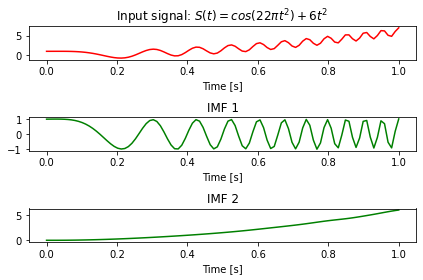

In [83]:
# Execute EMD on signal
IMF = EMD().emd(s, t)
N = IMF.shape[0]+1

# Plot results
plt.subplot(N,1,1)
plt.plot(t, s, 'r')
plt.title("Input signal: $S(t)=cos(22\pi t^2) + 6t^2$")
plt.xlabel("Time [s]")

for n, imf in enumerate(IMF):
    plt.subplot(N,1,n+2)
    plt.plot(t, imf, 'g')
    plt.title("IMF "+str(n+1))
    plt.xlabel("Time [s]")

plt.tight_layout()
#plt.savefig('simple_example')
plt.show()

In [84]:
IMF

array([[ 1.01839826e+00,  1.02135703e+00,  1.02341670e+00,
         1.02371115e+00,  1.02078173e+00,  1.01259020e+00,
         9.96551270e-01,  9.69598694e-01,  9.28302016e-01,
         8.69052790e-01,  7.88338513e-01,  6.83118474e-01,
         5.51306702e-01,  3.92351901e-01,  2.07881737e-01,
         2.34923608e-03, -2.16415915e-01, -4.36884133e-01,
        -6.43892883e-01, -8.19277255e-01, -9.43217504e-01,
        -9.96390654e-01, -9.62889710e-01, -8.33690280e-01,
        -6.10213679e-01, -3.07293069e-01,  4.53437183e-02,
         4.04019924e-01,  7.15260228e-01,  9.23447411e-01,
         9.81485971e-01,  8.62922802e-01,  5.72889198e-01,
         1.54464683e-01, -3.12982384e-01, -7.25801262e-01,
        -9.78316500e-01, -9.91788054e-01, -7.42850646e-01,
        -2.81595866e-01,  2.70142280e-01,  7.45693964e-01,
         9.83007154e-01,  8.83903410e-01,  4.61999936e-01,
        -1.43819428e-01, -7.05461123e-01, -9.88018573e-01,
        -8.52159954e-01, -3.32395104e-01,  3.53515629e-0

In [89]:
sum(IMF)

array([ 1.        ,  1.00058732,  1.00205093,  1.00349632,  1.00343644,
        0.99980465,  0.98998727,  0.97088965,  0.93905295,  0.89084031,
        0.82271084,  0.73159544,  0.61537974,  0.47348404,  0.30750761,
        0.12187508, -0.07561225, -0.2734532 , -0.45651363, -0.60665702,
       -0.70409204, -0.72952409, -0.66707458, -0.50774752, -0.25299261,
        0.08232859,  0.46845985,  0.861696  ,  1.20853335,  1.45332627,
        1.54895086,  1.46892672,  1.21836216,  0.84031484,  0.41413126,
        0.04344027, -0.16610454, -0.13577421,  0.15782873,  0.66465566,
        1.26291555,  1.78598156,  2.07184462,  2.0223709 ,  1.6512287 ,
        1.09735458,  0.58889482,  0.3608087 ,  0.55248491,  1.12948704,
        1.87413233,  2.46613588,  2.63154181,  2.29391873,  1.64280913,
        1.06145918,  0.9274091 ,  1.38337103,  2.21912366,  2.96455214,
        3.17180545,  2.72515387,  1.96038951,  1.47025909,  1.68784191,
        2.53536723,  3.43271111,  3.71948135,  3.20075676,  2.36

# PyEMD.EMD样例

In [85]:
! pip install EMD-signal

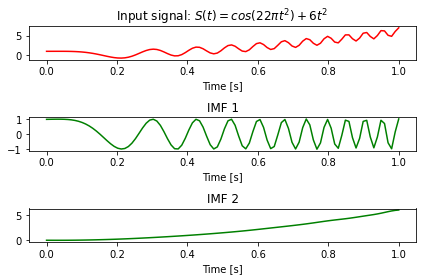

In [86]:
from PyEMD import EMD

# Execute EMD on signal
IMF = EMD().emd(s, t)
N = IMF.shape[0]+1

# Plot results
plt.subplot(N,1,1)
plt.plot(t, s, 'r')
plt.title("Input signal: $S(t)=cos(22\pi t^2) + 6t^2$")
plt.xlabel("Time [s]")

for n, imf in enumerate(IMF):
    plt.subplot(N,1,n+2)
    plt.plot(t, imf, 'g')
    plt.title("IMF "+str(n+1))
    plt.xlabel("Time [s]")

plt.tight_layout()
#plt.savefig('simple_example')
plt.show()

In [87]:
IMF

array([[ 9.81951782e-01,  9.86583913e-01,  9.90508064e-01,
         9.92816135e-01,  9.92011329e-01,  9.86032621e-01,
         9.72275768e-01,  9.47655572e-01,  9.08722629e-01,
         8.51849543e-01,  7.73504861e-01,  6.70628922e-01,
         5.41116805e-01,  3.84398263e-01,  2.02082014e-01,
        -1.39786795e-03, -2.18230645e-01, -4.36905684e-01,
        -6.42279400e-01, -8.16205835e-01, -9.38884191e-01,
        -9.91010444e-01, -9.56689420e-01, -8.26880031e-01,
        -6.02979772e-01, -2.99797980e-01,  5.29613357e-02,
         4.11645239e-01,  7.22802232e-01,  9.30838921e-01,
         9.88683624e-01,  8.69903509e-01,  5.79635942e-01,
         1.60962968e-01, -3.06744529e-01, -7.19833289e-01,
        -9.72625337e-01, -9.86382954e-01, -7.37760866e-01,
        -2.76868724e-01,  2.74443104e-01,  7.49488427e-01,
         9.86198852e-01,  8.86391245e-01,  4.63724800e-01,
        -1.42862986e-01, -7.05224893e-01, -9.88400688e-01,
        -8.53010904e-01, -3.33541798e-01,  3.52263842e-0

In [88]:
sum(IMF)

array([ 1.        ,  1.00058732,  1.00205093,  1.00349632,  1.00343644,
        0.99980465,  0.98998727,  0.97088965,  0.93905295,  0.89084031,
        0.82271084,  0.73159544,  0.61537974,  0.47348404,  0.30750761,
        0.12187508, -0.07561225, -0.2734532 , -0.45651363, -0.60665702,
       -0.70409204, -0.72952409, -0.66707458, -0.50774752, -0.25299261,
        0.08232859,  0.46845985,  0.861696  ,  1.20853335,  1.45332627,
        1.54895086,  1.46892672,  1.21836216,  0.84031484,  0.41413126,
        0.04344027, -0.16610454, -0.13577421,  0.15782873,  0.66465566,
        1.26291555,  1.78598156,  2.07184462,  2.0223709 ,  1.6512287 ,
        1.09735458,  0.58889482,  0.3608087 ,  0.55248491,  1.12948704,
        1.87413233,  2.46613588,  2.63154181,  2.29391873,  1.64280913,
        1.06145918,  0.9274091 ,  1.38337103,  2.21912366,  2.96455214,
        3.17180545,  2.72515387,  1.96038951,  1.47025909,  1.68784191,
        2.53536723,  3.43271111,  3.71948135,  3.20075676,  2.36